In [1]:
from scipy.cluster.vq import kmeans2
from pyro.infer import MCMC, NUTS, Predictive, SVI, TraceMeanField_ELBO
import pyro
import pyro.contrib.gp as gp
from pyro.contrib.examples.util import get_data_directory, get_data_loader
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_loader = get_data_loader(dataset_name='MNIST',
                               data_dir='~/.data',
                               batch_size=1000,
                               is_training_set=True,
                               shuffle=True)
test_loader = get_data_loader(dataset_name='MNIST',
                              data_dir='~/.data',
                              batch_size=1000,
                              is_training_set=False,
                              shuffle=False)

downloading data
download complete.
downloading data
download complete.


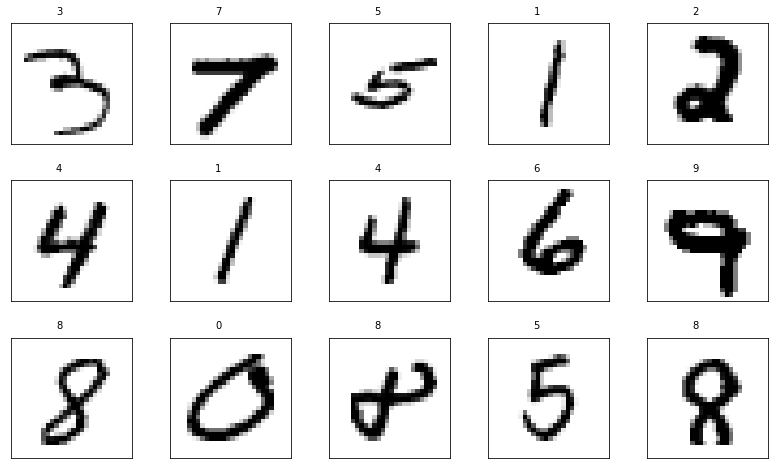

In [3]:
X = train_loader.dataset.data.float()/126
y = train_loader.dataset.targets
class_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(X.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for n, (image, label) in enumerate(zip(X[inx], y[inx])):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='binary')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -2.5, f'{class_names[label]}')
plt.show()

In [4]:
X = train_loader.dataset.data.reshape(-1, 784).float() / 255
y = train_loader.dataset.targets

In [5]:
class LinearT(nn.Module):
    """Linear transform and transpose"""
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x):
        return self.linear(x).t()

# computes the weight for mean function of the first layer;
# it is PCA of X (from 784D to 30D).
_, _, V = np.linalg.svd(X.numpy(), full_matrices=False)
W = torch.from_numpy(V[:30, :])

mean_fn = LinearT(784, 30)
mean_fn.linear.weight.data = W
mean_fn.linear.weight.requires_grad_(False)

Parameter containing:
tensor([[ 3.0388e-19,  2.2204e-16,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.5503e-20, -4.5103e-17,  3.1225e-17,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.7568e-19, -2.7756e-17, -2.0817e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 2.9082e-18,  1.8041e-16, -3.0531e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.2345e-18, -1.0408e-16,  1.2490e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.3574e-18,  3.4694e-17,  4.8572e-17,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [6]:
class DeepGP(pyro.nn.PyroModule):
    def __init__(self, X, y, Xu, mean_fn):
        super(DeepGP, self).__init__()
        self.layer1 = gp.models.VariationalSparseGP(
            X,
            None,
            gp.kernels.RBF(784, variance=torch.tensor(2.), lengthscale=torch.tensor(2.)),
            Xu=Xu,
            likelihood=None,
            mean_function=mean_fn,
            latent_shape=torch.Size([30]))
        # make sure that the input for next layer is batch_size x 30
        h = mean_fn(X).t()
        hu = mean_fn(Xu).t()
        self.layer2 = gp.models.VariationalSparseGP(
            h,
            y,
            gp.kernels.RBF(30, variance=torch.tensor(2.), lengthscale=torch.tensor(2.)),
            Xu=hu,
            likelihood=gp.likelihoods.MultiClass(num_classes=10),
            latent_shape=torch.Size([10]))

    def model(self, X, y):
        self.layer1.set_data(X, None)
        h_loc, h_var = self.layer1.model()
        # approximate with a Monte Carlo sample (formula 15 of [1])
        h = dist.Normal(h_loc, h_var.sqrt())()
        self.layer2.set_data(h.t(), y)
        self.layer2.model()

    def guide(self, X, y):
        self.layer1.guide()
        self.layer2.guide()

    # make prediction
    def forward(self, X_new):
        # because prediction is stochastic (due to Monte Carlo sample of hidden layer),
        # we make 100 prediction and take the most common one (as in [4])
        pred = []
        for _ in range(100):
            h_loc, h_var = self.layer1(X_new)
            h = dist.Normal(h_loc, h_var.sqrt())()
            f_loc, f_var = self.layer2(h.t())
            pred.append(f_loc.argmax(dim=0))
        return torch.stack(pred).mode(dim=0)[0]

In [7]:
Xu = torch.from_numpy(kmeans2(X.numpy(), 100, minit='points')[0])
deepgp = DeepGP(X, y, Xu, mean_fn)
deepgp.layer1.u_scale_tril = deepgp.layer1.u_scale_tril * 1e-5
#deepgp.cuda()

optimizer = torch.optim.Adam(deepgp.parameters(), lr=0.01)
loss_fn = TraceMeanField_ELBO().differentiable_loss

In [8]:
def train(train_loader, gpmodule, optimizer, loss_fn, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        data = data.reshape(-1, 784)
        optimizer.zero_grad()
        loss = loss_fn(gpmodule.model, gpmodule.guide, data, target)
        loss.backward()
        optimizer.step()
        idx = batch_idx + 1
        if idx % 10 == 0:
            print("Train Epoch: {:2d} [{:5d}/{} ({:2.0f}%)]\tLoss: {:.6f}"
                  .format(epoch, idx * len(data), len(train_loader.dataset),
                          100. * idx / len(train_loader), loss))

def test(test_loader, gpmodule):
    correct = 0
    for data, target in test_loader:
        data, target = data, target
        data = data.reshape(-1, 784)
        pred = gpmodule(data)
        # compare prediction and target to count accuaracy
        correct += pred.eq(target).long().cpu().sum().item()

    print("\nTest set: Accuracy: {}/{} ({:.2f}%)\n"
          .format(correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [9]:
for i in range(20):
    train(train_loader, deepgp, optimizer, loss_fn, i)
    with torch.no_grad():
        test(test_loader, deepgp)

Train Epoch:  0 [10000/60000 (17%)]	Loss: 215304.953125
Train Epoch:  0 [20000/60000 (33%)]	Loss: 204943.156250
Train Epoch:  0 [30000/60000 (50%)]	Loss: 201406.531250
Train Epoch:  0 [40000/60000 (67%)]	Loss: 195478.687500
Train Epoch:  0 [50000/60000 (83%)]	Loss: 177693.046875
Train Epoch:  0 [60000/60000 (100%)]	Loss: 145928.546875

Test set: Accuracy: 8420/10000 (84.20%)

Train Epoch:  1 [10000/60000 (17%)]	Loss: 101692.187500
Train Epoch:  1 [20000/60000 (33%)]	Loss: 69872.468750
Train Epoch:  1 [30000/60000 (50%)]	Loss: 56267.832031
Train Epoch:  1 [40000/60000 (67%)]	Loss: 54678.117188
Train Epoch:  1 [50000/60000 (83%)]	Loss: 51300.453125
Train Epoch:  1 [60000/60000 (100%)]	Loss: 51296.593750

Test set: Accuracy: 9323/10000 (93.23%)

Train Epoch:  2 [10000/60000 (17%)]	Loss: 49436.828125
Train Epoch:  2 [20000/60000 (33%)]	Loss: 46289.953125
Train Epoch:  2 [30000/60000 (50%)]	Loss: 45350.890625
Train Epoch:  2 [40000/60000 (67%)]	Loss: 48365.203125
Train Epoch:  2 [50000/6000